<h2>Titanic: Machine Learning from Disaster</h2>

>> The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

>> One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

>> In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

## Data Exploration

In [1]:
# Importing important libraries & the data set.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
%matplotlib inline

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
passenger_ids = test_df["PassengerId"]

# Have a peek at the data.

display(train_df.sample(n = 3))
display(test_df.sample(n = 3))

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
751,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S
833,834,0,3,"Augustsson, Mr. Albert",male,23.0,0,0,347468,7.8542,NaN,S
527,528,0,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
260,1152,3,"de Messemaeker, Mr. Guillaume Joseph",male,36.5,1,0,345572,17.4000,NaN,S
32,924,3,"Dean, Mrs. Bertram (Eva Georgetta Light)",female,33.0,1,2,C.A. 2315,20.5750,NaN,S
177,1069,1,"Stengel, Mr. Charles Emil Henry",male,54.0,1,0,11778,55.4417,C116,C


In [2]:
# Are there any missing values?, any variables that need to be converted to another type?

print("Training Data Info\n")
display(train_df.info())

print("Testing Data Info\n")
display(test_df.info())

Training Data Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


None

Testing Data Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None

#### Continious Features

1. Age
2. Fare

#### Categorical Feature

1. Sex
2. Embarked

#### Ordinal/Interval Features

1. Pclass
2. SibSp
3. Parch

#### The following columns have null values and need to be dropped or interpolated :

1. Age (Both in training and testing data)
2. Cabin (Both)
3. Embarked (Training data)
4. Fare (Testing data)

#### The following are variables we need to transform to get any information out of or need to drop them.

1. Name
2. Cabin
3. Ticket

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

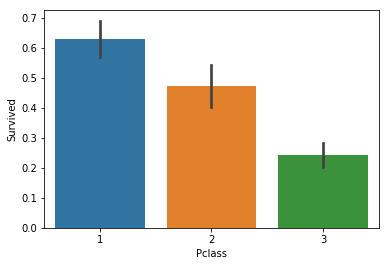

In [3]:
# Relationship b/w pclass and survived

survival_by_class = train_df.groupby("Pclass")["Survived"].mean()
display(survival_by_class)

sns.barplot(x="Pclass", y="Survived", data=train_df)
plt.show()

>> It is evident from the above analysis that better the Socio Economic Class, more the chances of survival.

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

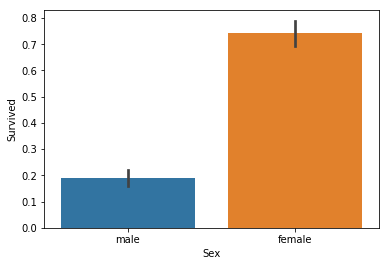

In [4]:
# Relationship b/w Sex and Survived

survival_by_sex = train_df.groupby("Sex")["Survived"].mean()
display(survival_by_sex)

sns.barplot(x = "Sex", y = "Survived", data = train_df)
plt.show()

>> It is evident from the above analysis that women had a higher chance of surviving.

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

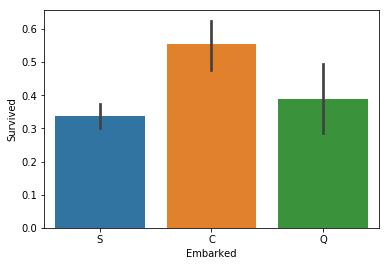

In [5]:
# Does the Port of Embarkation have any relation to Survival rate?

survival_by_port = train_df.groupby("Embarked")["Survived"].mean()
display(survival_by_port)

sns.barplot(x = "Embarked", y = "Survived", data = train_df)
plt.show()

>> Looks like there is correlation here. People who embarked from Cherbourg had a higher chance of survival than the other ports.

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64


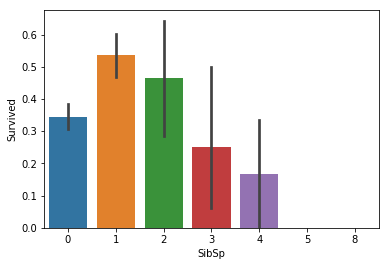

In [6]:
# TODO Find realtionship b/w Parch/ SibSp and Survival

print(train_df.groupby("SibSp")["Survived"].mean())

sns.barplot(x = "SibSp", y = "Survived", data = train_df)
plt.show()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64


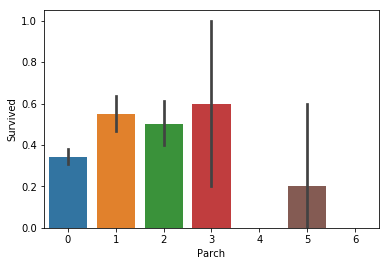

In [7]:
print(train_df.groupby("Parch")["Survived"].mean())

sns.barplot(x = "Parch", y = "Survived", data = train_df)
plt.show()

>> More Sibling or spouses, less the chances of survival. But people who had no sibling/ spouses had an even lesser chance of survival.

>> Were most of these people were males? Did these people help others before helping themselves ?

>> Same is the case with parch.

>> In a nutshell, Bigger families had less survival rate, but there survival rate is better then people who travelled alone.

## Feature Engineering

Lets do a little bit of feature engg.

This step is heavily taken from 'Sina'. See https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier

In [8]:
import math

# Has a cabin ?

def hasCabin(x):
    return int((x["Cabin"] is not np.nan))

train_df["HasCabin"] = train_df.apply(hasCabin, axis = 1)
test_df["HasCabin"] = test_df.apply(hasCabin, axis = 1)

# Combine SibSp & Parch to create a new variable

train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"] + 1
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"] + 1

# Use family size to create a new feature isAlone.

def isAlone(x):
    familySize = x["FamilySize"]
    return int(familySize == 1)

train_df["IsAlone"] = train_df.apply(isAlone, axis = 1)
test_df["IsAlone"] = test_df.apply(isAlone, axis = 1)

display(train_df.sample(n = 3))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,FamilySize,IsAlone
864,865,0,2,"Gill, Mr. John William",male,24.0,0,0,233866,13.0,NaN,S,0,1,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0,B42,S,1,1,1
435,436,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0,B96 B98,S,1,4,0


Lets study the effects of these newly created features on survival rate

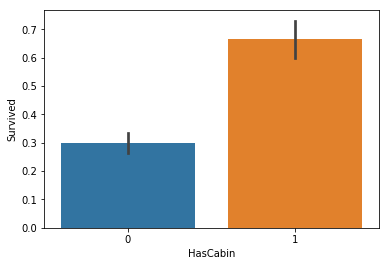

In [9]:
# 1. Cabin

sns.barplot(x = "HasCabin", y = "Survived", data = train_df)
plt.show()

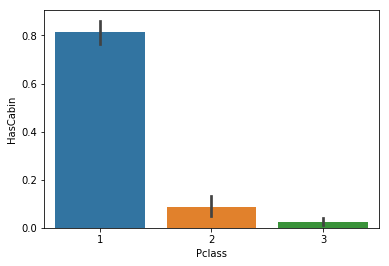

In [10]:
# People who had cabins are more likely to survive. Are most of these people from better socio economic background?

sns.barplot(x = "Pclass", y = "HasCabin", data = train_df)
plt.show()

# Looks like it!

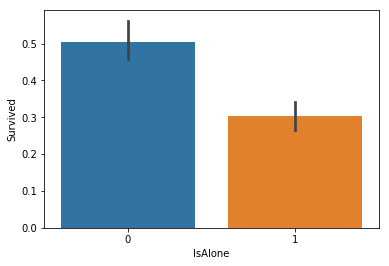

In [11]:
# 2. isAlone ?

sns.barplot(x = "IsAlone", y = "Survived", data = train_df)
plt.show()

# People who are alone are less likely to survive as discussed earlier.

In [12]:
train_df[train_df["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,FamilySize,IsAlone
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,1,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,1,1


In [13]:
# Since the ticket is first class and the persons survived, lets fill it with C

train_df["Embarked"] = train_df["Embarked"].fillna("C")

In [14]:
display(train_df.groupby(["Pclass", "Sex"])["Age"].mean())
# Interpolate Age using Pclass and Sex

train_df["Age"] = train_df.groupby(["Pclass", "Sex"])["Age"].transform(lambda x: x.fillna(x.mean()))
test_df["Age"] = test_df.groupby(["Pclass", "Sex"])["Age"].transform(lambda x: x.fillna(x.mean()))

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

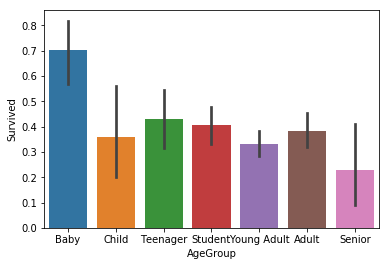

In [15]:
bins = [0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']

train_df['AgeGroup'] = pd.cut(train_df["Age"], bins, labels = labels)
test_df['AgeGroup'] = pd.cut(test_df["Age"], bins, labels = labels)

sns.barplot(x = "AgeGroup", y = "Survived", data = train_df)
# babies are more likely to survive

In [16]:
test_df["Fare"] = test_df.groupby("Pclass")["Fare"].transform(lambda x: x.fillna(x.mean()))

In [17]:
# Split Fare into bands

train_df['Fare_Range'] = pd.qcut(train_df['Fare'], 4)

train_df['Fare_cat'] = 0
train_df.loc[train_df['Fare'] <= 7.91,'Fare_cat'] = 0
train_df.loc[(train_df['Fare'] > 7.91) & (train_df['Fare']<=14.454),'Fare_cat'] = 1
train_df.loc[(train_df['Fare'] > 14.454) & (train_df['Fare']<=31),'Fare_cat'] = 2
train_df.loc[(train_df['Fare'] > 31) & (train_df['Fare']<=513),'Fare_cat'] = 3


test_df['Fare_Range'] = pd.qcut(test_df['Fare'], 4)

test_df['Fare_cat'] = 0
test_df.loc[test_df['Fare'] <= 7.91,'Fare_cat'] = 0
test_df.loc[(test_df['Fare'] > 7.91) & (test_df['Fare']<=14.454),'Fare_cat'] = 1
test_df.loc[(test_df['Fare'] > 14.454) & (test_df['Fare']<=31),'Fare_cat'] = 2
test_df.loc[(test_df['Fare'] > 31) & (test_df['Fare']<=513),'Fare_cat'] = 3

In [18]:
train_df = train_df.drop(labels=["PassengerId", "Name", "Ticket", "Cabin", "Fare", "Fare_Range", "Age"], axis=1)
test_df = test_df.drop(labels=["PassengerId", "Name", "Ticket", "Cabin", "Fare", "Fare_Range", "Age"], axis=1)

In [19]:
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

                      Survived    Pclass     SibSp     Parch  HasCabin  \
Survived              1.000000 -0.338481 -0.035322  0.081629  0.316912   
Pclass               -0.338481  1.000000  0.083081  0.018443 -0.725541   
SibSp                -0.035322  0.083081  1.000000  0.414838 -0.040460   
Parch                 0.081629  0.018443  0.414838  1.000000  0.036987   
HasCabin              0.316912 -0.725541 -0.040460  0.036987  1.000000   
FamilySize            0.016639  0.065997  0.890712  0.783111 -0.009175   
IsAlone              -0.203367  0.135207 -0.584471 -0.583398 -0.158029   
Fare_cat              0.295875 -0.628459  0.394248  0.393048  0.497108   
Sex_female            0.543351 -0.131900  0.114631  0.245489  0.140391   
Sex_male             -0.543351  0.131900 -0.114631 -0.245489 -0.140391   
Embarked_C            0.174718 -0.251139 -0.061970 -0.013725  0.218068   
Embarked_Q            0.003650  0.221009 -0.026354 -0.081228 -0.129572   
Embarked_S           -0.155660  0.0817

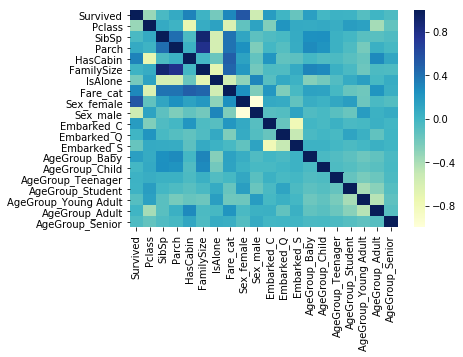

In [20]:
# Lets also solidify our findings using the correlation matrix

corr = train_df.corr()
print(corr)
sns.heatmap(corr, cmap = 'YlGnBu')

In [21]:
display(train_df.sample(n = 5))

,Survived,Pclass,SibSp,Parch,HasCabin,FamilySize,IsAlone,Fare_cat,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,AgeGroup_Baby,AgeGroup_Child,AgeGroup_Teenager,AgeGroup_Student,AgeGroup_Young Adult,AgeGroup_Adult,AgeGroup_Senior
776,0,3,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0
356,1,1,0,1,1,2,0,3,1,0,0,0,1,0,0,0,1,0,0,0
767,0,3,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0
748,0,1,1,0,1,2,0,3,0,1,0,0,1,0,0,0,1,0,0,0
90,0,3,0,0,0,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0


In [22]:
# Split into features and target variable
features = train_df.iloc[:, 1:]
target = train_df.iloc[:, 0]

## Feature Transformation

In [23]:
# Create a simple decision tree to see important features

from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(min_samples_split = 10)
classifier.fit(features, target)

print(features.columns)
print(classifier.feature_importances_)

Index(['Pclass', 'SibSp', 'Parch', 'HasCabin', 'FamilySize', 'IsAlone',
       'Fare_cat', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'AgeGroup_Baby', 'AgeGroup_Child', 'AgeGroup_Teenager',
       'AgeGroup_Student', 'AgeGroup_Young Adult', 'AgeGroup_Adult',
       'AgeGroup_Senior'],
      dtype='object')
[ 0.12121332  0.03588755  0.01799919  0.05632488  0.08295165  0.00872679
  0.05852103  0.45459038  0.          0.01328257  0.00637174  0.011869
  0.04830355  0.01934907  0.00251141  0.01019678  0.0316933   0.0192282
  0.00097959]


In [24]:
# split data into train and test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.1, random_state = 0)

/Users/ishans/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Model Application

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.cross_validation import ShuffleSplit

In [26]:
def findBestModel(classifier, params):
    cv_sets = ShuffleSplit(X_train.shape[0], n_iter = 15, test_size = 0.1, random_state = 0)
    score_fn = make_scorer(accuracy_score)
    grid = GridSearchCV(classifier, params, score_fn, cv = cv_sets)
    grid = grid.fit(X_train, y_train)
    best_clf = grid.best_estimator_
    print(best_clf)
    return best_clf

def calculateAccuracy(y_actual, y_pred):
    acc = accuracy_score(y_actual, y_pred)
    print("Model accuracy is {}\n".format(acc))
    return acc

* Ada Boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

classifier = AdaBoostClassifier(random_state = 0)
params = {"n_estimators" : [10, 50, 100, 150], "learning_rate" : [0.5, 0.75, 1, 1.25, 1.5]}

best_ada_model = findBestModel(classifier, params)

In [ ]:
best_ada_model.fit(X_train, y_train)
y_pred = best_ada_model.predict(X_test)

ada_accuracy = calculateAccuracy(y_test, y_pred)

* Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state = 0)
params = {"n_estimators" : [10, 25, 50, 75, 100], "min_samples_split" : [2, 5, 10, 15, 20, 50]}

best_random_model = findBestModel(classifier, params)

In [ ]:
best_random_model.fit(X_train, y_train)
y_pred = best_random_model.predict(X_test)

random_accuracy = calculateAccuracy(y_test, y_pred)

* SVM

In [ ]:
from sklearn.svm import SVC

classifier = SVC(random_state = 0)
params = {"C" : [0.5, 0.75, 1, 1.25, 1.5], "gamma" : [0.1, 0.2, 0.3, 0.5]}

best_svc_model = findBestModel(classifier, params)

In [ ]:
best_svc_model.fit(X_train, y_train)
y_pred = best_svc_model.predict(X_test)

svc_accuracy = calculateAccuracy(y_test, y_pred)

* Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(random_state = 0)
params = {"learning_rate" : [0.05, 0.1, 0.2, 0.3], "n_estimators" : [50, 100, 150, 200], "min_samples_split" : [2, 5, 8, 10, 20]}

best_gbc_model = findBestModel(classifier, params)

In [ ]:
best_gbc_model.fit(X_train, y_train)
y_pred = best_gbc_model.predict(X_test)

gbc_accuracy = calculateAccuracy(y_test, y_pred)

* Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)
params = {"C" : [0.5, 0.75, 1, 1.25, 1.5], "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"], "max_iter" : [100, 150, 200, 300]}

best_logistic_model = findBestModel(classifier, params)

best_logistic_model.fit(X_train, y_train)
y_pred = best_logistic_model.predict(X_test)
logistic_accuracy = calculateAccuracy(y_test, y_pred)

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines',  'Logistic Regression', 
              'Random Forest', 'Gradient Boosting Classifier', 'Ada Boost'],
    'Score': [svc_accuracy, logistic_accuracy, random_accuracy, gbc_accuracy, ada_accuracy]})
models = models.sort_values(by='Score', ascending=False)
display(models)

In [ ]:
# the actual score of GBC is 73% on kaggle. I dont know what i am doing wrong here. My untuned normal models have higher accuracy on kaggle.

In [ ]:
model = SVC()
model.fit(features, target)

survival = model.predict(test_df)

submit_df = pd.DataFrame({"PassengerId" : passenger_ids, "Survived" : survival})
submit_df = submit_df.set_index("PassengerId")
submit_df.to_csv("predictions.csv")